In [110]:
import pandas as pd
import numpy as np
import scipy as sp
import itertools

from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

In [76]:
def rmse(y_true,y_prediction):
    return np.sqrt(np.linalg.norm(np.array(y_true)-np.array(y_prediction))**2/len(y_true))

## read data

In [5]:
data = pd.read_csv(r'.\Tianchi_power\Tianchi_power.csv',parse_dates = [0],
                   dtype = {'power_consumption': np.int16, 'user_id': np.int16},
                   #na_values =[1],
                   encoding = 'gbk')
# fill missing value with 0
data_Org =data.pivot_table(values = 'power_consumption',index = 'record_date',
                           columns = 'user_id',fill_value = 0)
data_Org = data_Org.transpose()


In [8]:
holidayData = pd.read_csv(r'date.csv',parse_dates = [0])
holidayData_Org = holidayData
holidayData = holidayData.set_index('date')

#weather = pd.read_csv(r'yangzhong_weather.csv',parse_dates = [0])
weather = pd.read_csv('yangzhong_weather.csv',parse_dates = [0])
weather = weather.set_index('date')

## cosntruct model

In [6]:
from fbprophet import Prophet

In [25]:
holidayData2 = holidayData.copy().drop(['date_type_Org','dayOfWeek'],axis = 1).reset_index()

In [29]:
holidays = holidayData2.join(pd.DataFrame(np.ones([holidayData.shape[0],1])*-1,columns = ['lower_window']))\
    .join(pd.DataFrame(np.zeros([holidayData.shape[0],1]),columns = ['upper_window']))
holidays = holidays.rename(columns = {'date':'ds','date_type':'holiday'})
holidays_C = holidays.iloc[0:2,:]
for i in range(2,holidays.shape[0]):
    if holidays.holiday[i] not in '1234567':
        holidays_C = holidays_C.append(holidays.iloc[i,:])

In [30]:
data_All = data_Org.sum()
trainData = data_All.reset_index().rename(columns={'record_date':'ds',0:"y"})

m = Prophet(holidays=holidays_C,yearly_seasonality=True)
 
m.fit(trainData.iloc[:609-31,:])

future = m.make_future_dataframe(periods = 31)
forecast_All = m.predict(future)
sp.corrcoef(list(forecast_All.yhat[-31:]),list(data_All.iloc[-31:]))[0,1]

In [128]:
def test_Param(param_list,trainData,y,holidays_C):
    m = Prophet(holidays=holidays_C,yearly_seasonality=True)
    
    m.n_changepoints = param_list[0]
    m.seasonality_prior_scale = param_list[1]
    m.holidays_prior_scale = param_list[2]
    m.changepoint_prior_scale = param_list[3]
    m.fit(trainData.iloc[:578])
    
    future = m.make_future_dataframe(periods = 31)
    forecast_All = m.predict(future)
    return sp.corrcoef(list(forecast_All.yhat[-31:]),list(y.iloc[-31:]))[0,1]

In [117]:
param_test_product = itertools.product(param_test1['n_changepoints'],
                                       param_test1['seasonality_prior_scale'],
                                       param_test1['holidays_prior_scale'],
                                      param_test1['changepoint_prior_scale'])

In [129]:
for p in param_test_product:
    result.append([p,test_Param(p,trainData,data_All,m,holidays_C)])
    

KeyboardInterrupt: 

In [139]:
help(sorted)

Help on built-in function sorted in module builtins:

sorted(iterable, key=None, reverse=False)
    Return a new list containing all items from the iterable in ascending order.
    
    A custom key function can be supplied to customise the sort order, and the
    reverse flag can be set to request the result in descending order.



In [84]:
sp.corrcoef(list(forecast_All.yhat[-31:]),list(data_All.iloc[-31:]))[0,1]

0.41210537941757869

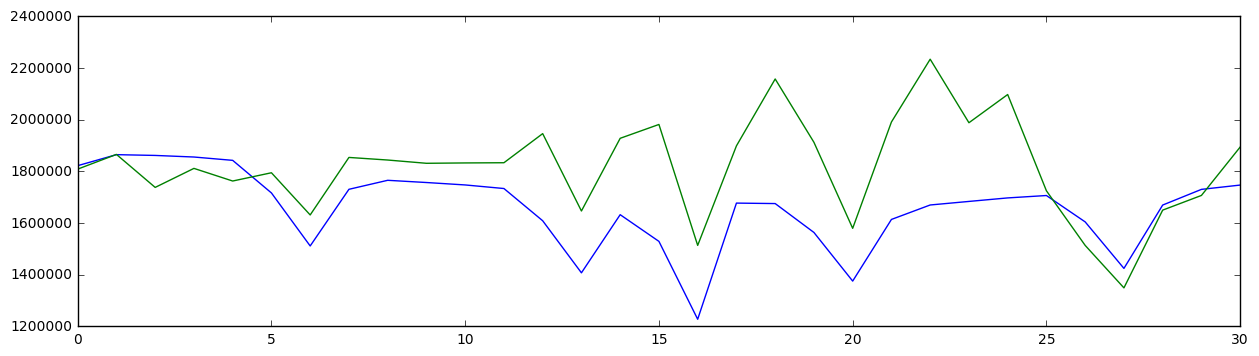

In [43]:
plt.figure(figsize = [15,4])
plt.plot(list(forecast_All.yhat[-31:]))
plt.plot(list(data_All.iloc[-31:]))

In [ ]:
dirmetr